In [1]:
import scipy.io as sio
import numpy as np
import torch
import os
from os import listdir
from os.path import isfile, join
from torch import nn, optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np 
import math
import pandas as pd
import cmath
import scipy.io as sio
import numpy as np
import torch
from torch import nn, optim
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np 
import math
import pandas as pd
import cmath

#from unet import UNet
# from auto import encoder, decoder

from collections import OrderedDict
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
#==========================================================================
# For Plotting loss graph
# Bokeh
from bokeh.io import curdoc
from bokeh.layouts import column
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure

from functools import partial
from threading import Thread
from tornado import gen
# from AttRCNN_UNet import Att_R2U
import logging
logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)
import sys
# from dataloader import norm
import csv
from sklearn.model_selection import train_test_split
from sys import getsizeof
# import wandb
# import logging
# logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)
import mat73

In [2]:
nq_type = "NS" # Sub-Nyquist or Nyquist sample
no_samples = 300
no_doa = 4

In [3]:
root_dataset_path =  ("../../datasets/300/DOA4")

In [4]:
def create_dataset(df, dataset_type):
  
    data = np.transpose(df[dataset_type], (2, 0, 1))
    label = df['DOA']
    X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.10, random_state=42)
    del data
    del label
    return X_train, X_test, y_train, y_test

In [5]:
def get_data(train, label, batch_size, train_bool=True):
    class DOA_dataset(Dataset):
        def __init__(self, train, test):
            self.x = torch.from_numpy(np.array(train))
            self.y = torch.from_numpy(np.asarray(label))
            self.n_sample = len(self.y)
        def __getitem__(self, index):
            return self.x[index], self.y[index]
        def __len__(self):
            return self.n_sample


    dataset = DOA_dataset(train, label)
    

    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=train_bool)
    return loader

In [6]:
def create_dataloader(root_path, dataset_type, ss):
    # Loading all dataset 
    logging.info('Data prepration started')
    df1  = mat73.loadmat(root_path + "/SNR_{}_0_{}_{}.mat".format(nq_type, no_doa, no_samples))
    df2  = mat73.loadmat(root_path + "/SNR_{}_10_{}_{}.mat".format(nq_type, no_doa, no_samples))
    df3  = mat73.loadmat(root_path + "/SNR_{}_20_{}_{}.mat".format(nq_type, no_doa, no_samples))
    df4  = mat73.loadmat(root_path + "/SNR_{}_30_{}_{}.mat".format(nq_type, no_doa, no_samples))
    df5  = mat73.loadmat(root_path + "/SNR_{}_40_{}_{}.mat".format(nq_type, no_doa, no_samples))
#     df1  = sio.loadmat("../../SNS_dataset/100/DOA5/SNR_SNS_00_5.mat")
#     df2  = sio.loadmat("../../SNS_dataset/100/DOA5/SNR_SNS_10_5.mat")
#     df3  = sio.loadmat("../../SNS_dataset/100/DOA5/SNR_SNS_20_5.mat")
#     df4  = sio.loadmat("../../SNS_dataset/100/DOA5/SNR_SNS_30_5.mat")
#     df5  = sio.loadmat("../../SNS_dataset/100/DOA5/SNR_SNS_40_5.mat")
    df = [df1, df2, df3, df4, df5]

    new_train_dataset_list = []
    new_test_dataset_list = []
    train_dataset_list_label = []
    test_dataset_list_label = []

    dataset_len = 0
    if dataset_type == "SNS":
        dataset_len = ss//10
    if dataset_type == "NS":
        dataset_len = ss

    for idx, file in enumerate(df):
        X_train, X_test, y_train, y_test = create_dataset(file, dataset_type+"_data")
        if idx == 0:
          del df1
          print("df1 is deleted")
        elif idx == 1:
          del df2
        elif idx == 2:
          del df3
        elif idx == 3:
          del df4
        elif idx == 4:
          del df5
        new_train_dataset_list.extend(X_train)
        new_test_dataset_list.append(X_test.tolist())
        train_dataset_list_label.extend(y_train)
        test_dataset_list_label.append(y_test.tolist())

    # Deleteing all unused memory
    del df

    # Dividing into different channels
    logging.info('Dividing your dataset into 3 channel')

    for idx, data in enumerate(new_train_dataset_list):
        new = np.zeros((3, 8, dataset_len))
        for j in range(0, data.shape[0]):
            for k in range(0, data.shape[1]):
                new[0][j][k] = data[j][k].real
                new[1][j][k] = data[j][k].imag
                new[2][j][k] = cmath.phase(data[j][k])
        new_train_dataset_list[idx] = new

    for idx, data in enumerate(new_test_dataset_list):
        for i, ndata in enumerate(data):
            new = np.zeros((3, 8, dataset_len))
            for j in range(0, 8):
                for k in range(0, dataset_len):
                    new[0][j][k] = ndata[j][k].real
                    new[1][j][k] = ndata[j][k].imag
                    new[2][j][k] = cmath.phase(ndata[j][k])
            new_test_dataset_list[idx][i] = new

    # Generaring train loader
    logging.info('Creating Train dataloader')
    doa_train_loader = get_data(new_train_dataset_list, train_dataset_list_label, 16, True)

    # Deleteing all unused memory
    del new_train_dataset_list
    del train_dataset_list_label

    test_dataset_list = []
    logging.info('Creating Validation dataloader')
    for idx, data in enumerate(new_test_dataset_list):
        f = get_data(data, test_dataset_list_label[idx], 64, False)
        test_dataset_list.append(f)

    # Deleteing all unused memory
    del new_test_dataset_list
    del new
    logging.info('Your dataset is ready !!')
    return doa_train_loader ,test_dataset_list

In [7]:
doa_train_loader , test_dataset_list = create_dataloader(root_dataset_path, "NS", 300)

2021-07-11 16:11:31,921 - Data prepration started


df1 is deleted


2021-07-11 16:14:46,631 - Dividing your dataset into 3 channel
2021-07-11 16:58:56,224 - Creating Train dataloader
2021-07-11 16:59:06,481 - Creating Validation dataloader
2021-07-11 16:59:06,938 - Your dataset is ready !!


In [8]:
for j,(features, labels) in enumerate(doa_train_loader, 0):
    features, labels = Variable(features.cuda()), Variable(labels.cuda())
    print(features.size())
    print(labels.size())
    break

torch.Size([16, 3, 8, 300])
torch.Size([16, 4])


In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=(3,3), stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=(3,3), stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.relu2 = nn.ReLU(inplace=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu2(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=181):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=(1,3), stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=1)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=1)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=1)
        self.linear = nn.Linear(25, num_classes)
        self.adp_pool = nn.AdaptiveMaxPool2d((no_doa, 25))
        #self.flat = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=1, stride=1)
        self.flat = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=1, stride=1)
        self.dropout = nn.Dropout(0.6)
        self.dropout1 = nn.Dropout(0.5)
        self.relu = nn.ReLU(inplace=True)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
#         out = self.dropout(out)
        out = self.layer4(out)
#         out = self.dropout1(out)
        out = self.adp_pool(out)
        out = self.linear(out)
#         out = self.dropout1(out)
        out = self.flat(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [2, 3, 5, 2])

def ResNet101():
    return ResNet(BasicBlock, [3, 4, 23, 3])


if __name__ == "__main__":
    image = torch.rand(1, 3, 10, 100)
    model = ResNet34()
    print(model(image).size())


torch.Size([1, 1, 4, 181])


In [15]:
class FocalLoss(nn.modules.loss._WeightedLoss):
    def __init__(self, weight=None, gamma=2,reduction='mean'):
        super(FocalLoss, self).__init__(weight,reduction=reduction)
        self.gamma = gamma
        self.weight = weight #weight parameter will act as the alpha parameter to balance class weights

    def forward(self, input, target):
        ce_loss = F.cross_entropy(input, target,reduction=self.reduction,weight=self.weight)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss

In [20]:
num_epochs = 40

weights_dir = "../doa_weights"

autoencoder = ResNet34()
cross_criterion = nn.CrossEntropyLoss()
focal_criterion = FocalLoss()
if ('{}_DOA_{}_{}_model.pth'.format(nq_type, no_doa, no_samples) in [f for f in listdir(weights_dir) if isfile(join(weights_dir, f))]):
    print("Pre-trained available for DOA_{}_{}_model.pth".format(no_doa, no_samples))
    autoencoder = torch.load(os.path.join(weights_dir, '{}_DOA_{}_{}_model.pth'.format(nq_type, no_doa, no_samples)))

# model = nn.Sequential( pre_trained, autoencoder)
# model = ConvAutoencoder()
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
    classification_model = autoencoder.cuda()
    optimizer = optim.AdamW(classification_model.parameters(), lr=0.001, weight_decay=1e-5)
  
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", factor=0.05, patience=3, verbose=True)

Pre-trained available for DOA_4_300_model.pth
GeForce GTX 1080 Ti


In [27]:
acc_res = {
    "training": [],
    0: [],
    10: [],
    20: [],
    30: [],
    40: []
}
loss_res = {
    "training": [],
    0: [],
    10: [],
    20: [],
    30: [],
    40: []
}
mae_res = {
    "training": [],
    0: [],
    10: [],
    20: [],
    30: [],
    40: []
}

In [ ]:
%%time
print(no_doa)
def train():
    print("Training Starts !!!!!!!")
    best_valid_loss = float('Inf')
    for i in range(num_epochs):
        training_loss = 0
        train_correct = 0
        train_total = 0
        epoch_loss = 0.0
        training_mae = 0.0
        classification_model.train()
        criterion = None
        if (i+1)>=25 :
          print("Criterion is changed to focal loss")
          criterion = focal_criterion.cuda()
        else:
          criterion = cross_criterion.cuda()
        for j,(features, labels) in enumerate(doa_train_loader, 0):
            features, labels = Variable(features.cuda()), Variable(labels.cuda())
            optimizer.zero_grad()
            enn = classification_model(features.float())
            auto_outputs = torch.transpose(enn, 2, 3)
            auto_outputs = torch.reshape(auto_outputs.cuda(), (auto_outputs.shape[0], 181, no_doa))
            losss = criterion(auto_outputs.cuda(), labels.type(torch.LongTensor).cuda())
            losss.backward()
            optimizer.step()
#           exp_scheduler.step()
            training_loss += losss.item()

            _, pred = torch.max(auto_outputs, 1)

            train_total+= labels.reshape(-1).size(0)

            train_correct+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()

            epoch_loss += auto_outputs.shape[0] * losss.item()
            training_mae += torch.mean(torch.abs(pred.float().cuda() - labels.float()))

        loss_res['training'].append(training_loss/len(doa_train_loader))
        acc_res['training'].append((100*(train_correct/train_total)))
        mae_res['training'].append(training_mae/(len(doa_train_loader)*181))
        print('Epoch [{}/{}], Training Loss: {:.4f}, Training Accuracy: {:.4f}, Training MAE: {}'
                      .format(i+1, num_epochs, training_loss/len(doa_train_loader), (100*(train_correct/train_total)), training_mae/(len(doa_train_loader)*181)))
        
        # Validation for each SNR value
        classification_model.eval()
        total_valdation_loss = 0
        zero_val = 0
        for val_data in range(0, len(test_dataset_list)):
            
            validation_loss = 0
            validation_acc = 0
            validation_mae = 0.0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for features, labels in test_dataset_list[val_data]:
                    features, labels = Variable(features.cuda()), Variable(labels.cuda())
                    enn = classification_model(features.float())
                    auto_outputs = torch.transpose(enn, 2, 3)
                    auto_outputs = torch.reshape(auto_outputs, (auto_outputs.shape[0], 181, no_doa))
                    loss = criterion(auto_outputs.cuda(), labels.type(torch.LongTensor).cuda())

                    _, pred = torch.max(auto_outputs, 1)
                    val_total+= labels.reshape(-1).size(0)
                    val_correct+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()
                    validation_loss += loss.item()
                    validation_mae += torch.mean(torch.abs(pred.float().cuda() - labels.float()))

                loss_res[10*val_data].append(validation_loss/len(test_dataset_list[val_data]))
                acc_res[10*val_data].append((100*(val_correct/val_total)))
                
                mae_res[10*val_data].append(validation_mae/(len(test_dataset_list[val_data])*181))
                print('SNR [{}dB], Validation Loss: {:.4f}, Validation Accuracy: {:.4f}, Validation MAE: {}'
                      .format(val_data*10, validation_loss/len(test_dataset_list[val_data]), (100*(val_correct/val_total)), validation_mae/(len(test_dataset_list[val_data])*181)))

                total_valdation_loss+=validation_loss

        scheduler.step(loss_res[0][len(loss_res[0])-1])
        # print("Odb Loss => ", loss_res[0][len(loss_res[0])-1])
        # print("Lr -> ", optimizer.state_dict()["param_groups"][0]['lr'])
        torch.save( classification_model, weights_dir+ "/{}_DOA_{}_{}_model.pth".format(nq_type, no_doa, no_samples))
        if best_valid_loss > total_valdation_loss:
            best_valid_loss = total_valdation_loss 
            # Saving Best Pre-Trained Model as .pth file
            torch.save( classification_model, weights_dir+ "/{}_DOA_{}_{}_best_model.pth".format(nq_type, no_doa, no_samples))
#         if i%10 == 0:
#           ddf = pd.DataFrame(acc_res)
#           ddf.to_csv(weights_dir+"res_DOA_{}_model.csv".format(doa))
        print("\n")

train()
print("Training Complete")


4
Training Starts !!!!!!!
Epoch [1/40], Training Loss: 0.9946, Training Accuracy: 64.7920, Training MAE: 0.014075463637709618
SNR [0dB], Validation Loss: 2.3135, Validation Accuracy: 30.9175, Validation MAE: 0.044265151023864746
SNR [10dB], Validation Loss: 1.0641, Validation Accuracy: 60.9875, Validation MAE: 0.01349654234945774
SNR [20dB], Validation Loss: 0.6104, Validation Accuracy: 75.8175, Validation MAE: 0.006414238829165697
SNR [30dB], Validation Loss: 0.5337, Validation Accuracy: 78.4750, Validation MAE: 0.006061512045562267
SNR [40dB], Validation Loss: 0.5220, Validation Accuracy: 79.3175, Validation MAE: 0.005660124123096466


Epoch [2/40], Training Loss: 0.9510, Training Accuracy: 66.1854, Training MAE: 0.013541273772716522
SNR [0dB], Validation Loss: 2.2681, Validation Accuracy: 30.6125, Validation MAE: 0.0442742221057415
SNR [10dB], Validation Loss: 1.0623, Validation Accuracy: 60.9850, Validation MAE: 0.013785074464976788
SNR [20dB], Validation Loss: 0.6171, Validation A

In [21]:
%%time
def train():
    print("Training Starts !!!!!!!")
    best_valid_loss = float('Inf')
    for i in range(num_epochs):
        training_loss = 0
        train_correct = 0
        train_total = 0
        epoch_loss = 0.0
        training_mae = 0.0
        classification_model.train()
        criterion = None
        if (i+1)>=25 :
          print("Criterion is changed to focal loss")
          criterion = focal_criterion.cuda()
        else:
          criterion = cross_criterion.cuda()
        for j,(features, labels) in enumerate(doa_train_loader, 0):
            features, labels = Variable(features.cuda()), Variable(labels.cuda())
            optimizer.zero_grad()
            enn = classification_model(features.float())
            auto_outputs = torch.transpose(enn, 2, 3)
            auto_outputs = torch.reshape(auto_outputs.cuda(), (auto_outputs.shape[0], 181, no_doa))
            losss = criterion(auto_outputs.cuda(), labels.type(torch.LongTensor).cuda())
            losss.backward()
            optimizer.step()
#           exp_scheduler.step()
            training_loss += losss.item()

            _, pred = torch.max(auto_outputs, 1)

            train_total+= labels.reshape(-1).size(0)

            train_correct+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()

            epoch_loss += auto_outputs.shape[0] * losss.item()
            training_mae += torch.mean(torch.abs(pred.float().cuda() - labels.float()))

        loss_res['training'].append(training_loss/len(doa_train_loader))
        acc_res['training'].append((100*(train_correct/train_total)))
        mae_res['training'].append(training_mae/(len(doa_train_loader)*181))
        print('Epoch [{}/{}], Training Loss: {:.4f}, Training Accuracy: {:.4f}, Training MAE: {}'
                      .format(i+1, num_epochs, training_loss/len(doa_train_loader), (100*(train_correct/train_total)), training_mae/(len(doa_train_loader)*181)))
        
        # Validation for each SNR value
        classification_model.eval()
        total_valdation_loss = 0
        zero_val = 0
        for val_data in range(0, len(test_dataset_list)):
            
            validation_loss = 0
            validation_acc = 0
            validation_mae = 0.0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for features, labels in test_dataset_list[val_data]:
                    features, labels = Variable(features.cuda()), Variable(labels.cuda())
                    enn = classification_model(features.float())
                    auto_outputs = torch.transpose(enn, 2, 3)
                    auto_outputs = torch.reshape(auto_outputs, (auto_outputs.shape[0], 181, no_doa))
                    loss = criterion(auto_outputs.cuda(), labels.type(torch.LongTensor).cuda())

                    _, pred = torch.max(auto_outputs, 1)
                    val_total+= labels.reshape(-1).size(0)
                    val_correct+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()
                    validation_loss += loss.item()
                    validation_mae += torch.mean(torch.abs(pred.float().cuda() - labels.float()))

                loss_res[10*val_data].append(validation_loss/len(test_dataset_list[val_data]))
                acc_res[10*val_data].append((100*(val_correct/val_total)))
                
                mae_res[10*val_data].append(validation_mae/(len(test_dataset_list[val_data])*181))
                print('SNR [{}dB], Validation Loss: {:.4f}, Validation Accuracy: {:.4f}, Validation MAE: {}'
                      .format(val_data*10, validation_loss/len(test_dataset_list[val_data]), (100*(val_correct/val_total)), validation_mae/(len(test_dataset_list[val_data])*181)))

                total_valdation_loss+=validation_loss

        scheduler.step(loss_res[0][len(loss_res[0])-1])
        # print("Odb Loss => ", loss_res[0][len(loss_res[0])-1])
        # print("Lr -> ", optimizer.state_dict()["param_groups"][0]['lr'])
        torch.save( classification_model, weights_dir+ "/{}_DOA_{}_{}_model.pth".format(nq_type, no_doa, no_samples))
        if best_valid_loss > total_valdation_loss:
            best_valid_loss = total_valdation_loss 
            # Saving Best Pre-Trained Model as .pth file
            torch.save( classification_model, weights_dir+ "/{}_DOA_{}_{}_best_model.pth".format(nq_type, no_doa, no_samples))
#         if i%10 == 0:
#           ddf = pd.DataFrame(acc_res)
#           ddf.to_csv(weights_dir+"res_DOA_{}_model.csv".format(doa))
        print("\n")

train()
print("Training Complete")

Training Starts !!!!!!!
Epoch [1/40], Training Loss: 5.2556, Training Accuracy: 0.5544, Training MAE: 0.32763445377349854
SNR [0dB], Validation Loss: 5.1967, Validation Accuracy: 0.5967, Validation MAE: 0.33463284373283386
SNR [10dB], Validation Loss: 5.1967, Validation Accuracy: 0.5100, Validation MAE: 0.3342171907424927
SNR [20dB], Validation Loss: 5.1966, Validation Accuracy: 0.5733, Validation MAE: 0.3375367522239685
SNR [30dB], Validation Loss: 5.1967, Validation Accuracy: 0.6100, Validation MAE: 0.33536726236343384
SNR [40dB], Validation Loss: 5.1964, Validation Accuracy: 0.5400, Validation MAE: 0.33527565002441406


Epoch [2/40], Training Loss: 4.3405, Training Accuracy: 4.4584, Training MAE: 0.21578432619571686
SNR [0dB], Validation Loss: 4.3307, Validation Accuracy: 4.5433, Validation MAE: 0.3245415687561035
SNR [10dB], Validation Loss: 3.6446, Validation Accuracy: 8.9433, Validation MAE: 0.2411016970872879
SNR [20dB], Validation Loss: 3.4968, Validation Accuracy: 10.5667, Val

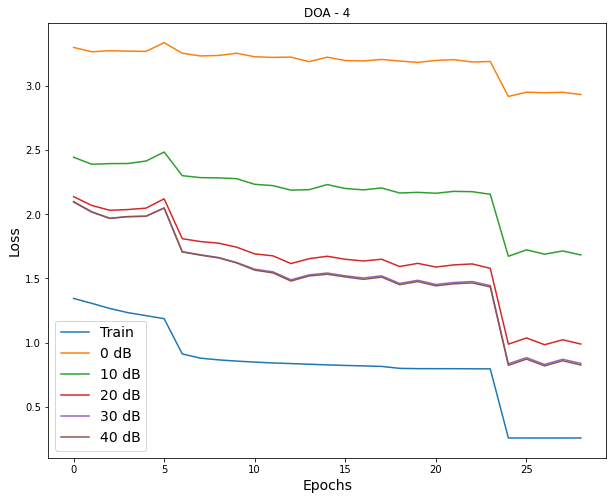

In [25]:
import matplotlib.pyplot as plt
ep = range(0, len(loss_res["training"])-1)
plt.figure(figsize=(10, 8))
plt.plot(ep, loss_res["training"][0:29], label='Train')
plt.plot(ep, loss_res[0], label='0 dB')
plt.plot(ep, loss_res[10], label='10 dB')
plt.plot(ep, loss_res[20], label='20 dB')
plt.plot(ep, loss_res[30], label='30 dB')
plt.plot(ep, loss_res[40], label='40 dB')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title("DOA - {}".format(no_doa))
plt.legend(fontsize=14)
plt.show()